In [176]:
import cv2 as cv
import numpy as np 
import matplotlib.pyplot as plt 

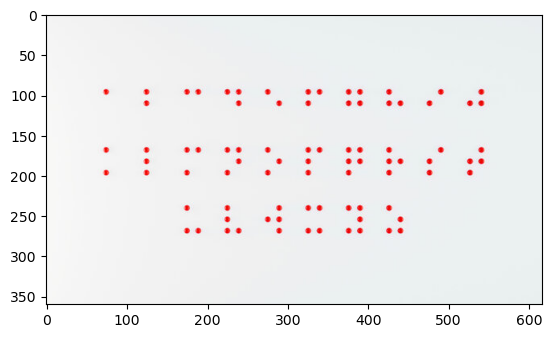

In [177]:
img = cv.imread('braille5.jpg')
img = cv.cvtColor(img,cv.COLOR_BGR2RGB)

h,w,c = img.shape

if w > 1000:
    new_w = 1000
    ar = w/h
    new_h = int(new_w/ar)

    img = cv.resize(img,(new_w,new_h),interpolation=cv.INTER_AREA)
plt.imshow(img)

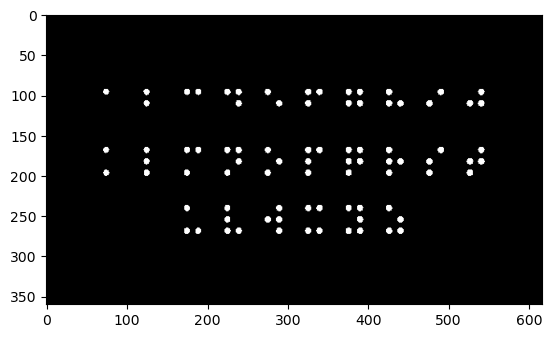

In [178]:
def thresholding(image):
    blur = cv.GaussianBlur(image,(7,7),0)
    img_gray = cv.cvtColor(blur,cv.COLOR_BGR2GRAY)
    ret,thresh = cv.threshold(img_gray,0,255,cv.THRESH_BINARY_INV + cv.THRESH_OTSU)
    plt.imshow(thresh, cmap='gray')
    return thresh

thresh_img = thresholding(img);

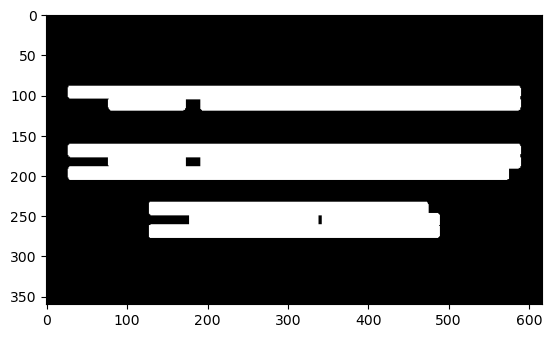

In [179]:
#dilation
kernel = np.ones((10,90), np.uint8)
dilated = cv.dilate(thresh_img, kernel, iterations = 1)
plt.imshow(dilated, cmap='gray');

In [180]:
(contours, heirarchy) = cv.findContours(dilated.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
sorted_contours_lines = sorted(contours, key = lambda ctr : cv.boundingRect(ctr)[1]) # (x, y, w, h)

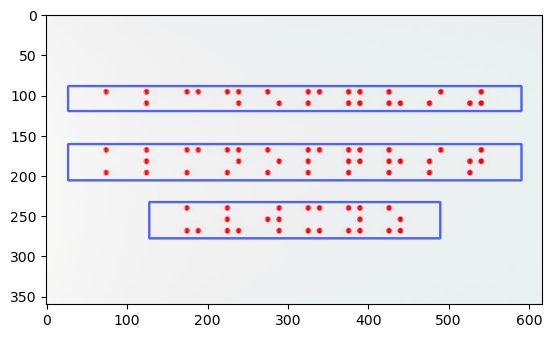

In [181]:
img2 = img.copy()
line_images = []


for ctr in sorted_contours_lines:
    
    x,y,w,h = cv.boundingRect(ctr)
    cv.rectangle(img2, (x,y), (x+w, y+h), (80, 100, 250), 2)

     # Crop each line and store it in the line_images array
    line_image = img[y:y + h, x:x + w]
    line_images.append(line_image)

    
plt.imshow(img2);

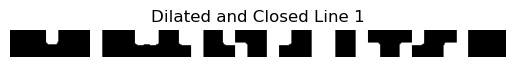

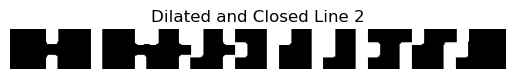

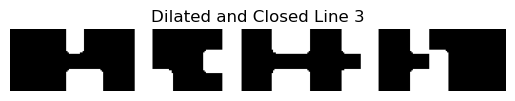

In [182]:
# Iterate over each line image and apply the processing steps
dialated_imgs=[]
for i, line_img in enumerate(line_images):
    # Step 1: Apply thresholding
    thresh_img = thresholding(line_img)
    
    # Step 2: Apply dilation and morphological closing
    kernel = np.ones((10, 7), np.uint8)
    dilated_img = cv.dilate(thresh_img, kernel, iterations=1)
    dilated_img = cv.morphologyEx(dilated_img, cv.MORPH_CLOSE, kernel)
    dialated_imgs.append(dilated_img)
    
    # Display the processed result for each line
    # plt.figure(figsize=(10, 5))
    # plt.subplot(1, 2, 1)
    # plt.imshow(thresh_img, cmap='gray')
    # plt.title(f"Thresholded Line {i + 1}")
    # plt.axis('off')
    
    plt.imshow(dilated_img, cmap='gray')
    plt.title(f"Dilated and Closed Line {i + 1}")
    plt.axis('off')
    
    plt.show()


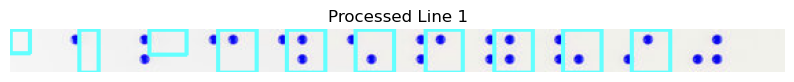

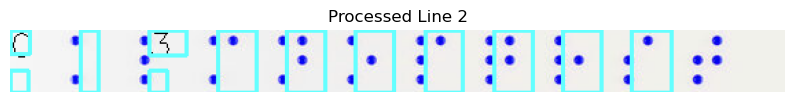

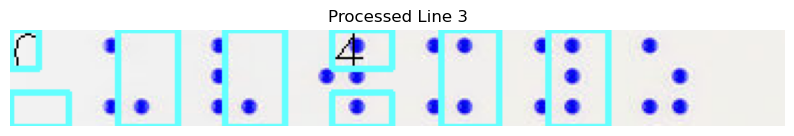

Word Coordinates: [[41, 0, 55, 17], [91, 0, 105, 31], [142, 0, 169, 18], [192, 0, 220, 31], [242, 0, 270, 31], [292, 0, 320, 31], [343, 0, 370, 31], [393, 0, 421, 31], [443, 0, 471, 31], [493, 0, 521, 31], [41, 29, 54, 45], [41, 0, 55, 17], [92, 0, 105, 45], [142, 29, 155, 45], [142, 0, 169, 18], [192, 0, 220, 45], [242, 0, 270, 45], [292, 0, 320, 45], [343, 0, 370, 45], [393, 0, 421, 45], [443, 0, 471, 45], [493, 0, 522, 45], [41, 29, 68, 45], [41, 0, 54, 18], [91, 0, 119, 45], [141, 0, 169, 45], [191, 29, 219, 45], [191, 0, 219, 18], [242, 0, 269, 45], [292, 0, 320, 45]]


In [183]:
# Clear the word list before starting
word_list = []

# Iterate over each line image in `dialated_imgs` and corresponding original line image
for line_index, diaimg in enumerate(dialated_imgs):
    # Get the bounding box for the line image to use as a reference
    x, y, w, h = cv.boundingRect(diaimg)
    roi_line = diaimg[y:y + h, x:x + w]

    # Ensure `roi_line` is grayscale
    if len(roi_line.shape) == 3:
        roi_line = cv.cvtColor(roi_line, cv.COLOR_BGR2GRAY)

    # Find contours within `roi_line`
    cnt, _ = cv.findContours(roi_line.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    sorted_contour_words = sorted(cnt, key=lambda cntr: cv.boundingRect(cntr)[0])

    # Iterate over each word in the line
    for word_index, word in enumerate(sorted_contour_words):
        # Get bounding box for each word
        x2, y2, w2, h2 = cv.boundingRect(word)

        # Store bounding box coordinates relative to the original line position
        word_list.append([x + x2, y + y2, x + x2 + w2, y + y2 + h2])

        # Draw bounding box and index label on the original line image
        cv.rectangle(line_images[line_index], (x2, y2), (x2 + w2, y2 + h2), (255, 255, 100), 2)
        cv.putText(line_images[line_index], str(word_index), (x2, y2 - 10), cv.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 0), 1)

    # Display each processed line image with bounding boxes for verification
    plt.figure(figsize=(10, 5))
    plt.imshow(cv.cvtColor(line_images[line_index], cv.COLOR_BGR2RGB))
    plt.title(f"Processed Line {line_index + 1}")
    plt.axis('off')
    plt.show()

# Print all word coordinates for verification
print("Word Coordinates:", word_list)
